In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Optional but helpful: tidy plots
plt.rcParams.update({"figure.figsize": (10, 6), "axes.grid": True})

# Try to import model libraries; provide guidance if missing
try:
    import xgboost as xgb
except Exception as e:
    print("Warning: xgboost not available. Install with: pip install xgboost")
    xgb = None

try:
    import lightgbm as lgb
except Exception as e:
    print("Warning: lightgbm not available. Install with: pip install lightgbm")
    lgb = None

from pathlib import Path

In [7]:
# Configure model file paths
BASE_DIR = Path.cwd()
MODEL_DIR = BASE_DIR / "model"

XGB_MODEL_PATH = MODEL_DIR / "xgboost_model.joblib"
LGBM_MODEL_PATH = MODEL_DIR / "lgbm_prediction_model.joblib"
TARGET_ENCODER_PATH = MODEL_DIR / "target_encoder.joblib"  # optional, if needed later

print("Model dir:", MODEL_DIR)
print("Exists:", MODEL_DIR.exists())
print("XGB:", XGB_MODEL_PATH.exists(), "LGBM:", LGBM_MODEL_PATH.exists())

Model dir: d:\WorkSpace\Study\DoAn2\model
Exists: True
XGB: True LGBM: True


In [8]:
# Utility: safe load + feature name extraction
from typing import Optional, Sequence, Tuple


def load_joblib(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"Missing model file: {path}")
    return joblib.load(path)


def get_xgb_feature_info(model) -> Tuple[Optional[Sequence[str]], Optional[np.ndarray]]:
    names = None
    importances = None
    try:
        # sklearn wrapper case
        if hasattr(model, "feature_importances_"):
            importances = np.asarray(model.feature_importances_, dtype=float)
        # Booster case or fallback to booster
        booster = model.get_booster() if hasattr(model, "get_booster") else (model if hasattr(model, "get_score") else None)
        if booster is not None:
            try:
                # Try gain-based dict first (preferred)
                gain_map = booster.get_score(importance_type="gain")
                if gain_map:
                    # Keep consistent order with feature names if available
                    names = list(gain_map.keys())
                    importances = np.asarray([gain_map[k] for k in names], dtype=float)
                if names is None:
                    # Try feature names from booster
                    bn = getattr(booster, "feature_names", None)
                    if bn:
                        names = list(bn)
            except Exception:
                pass
        # Try sklearn feature_names_in_
        if names is None and hasattr(model, "feature_names_in_"):
            names = [str(x) for x in model.feature_names_in_]
    except Exception:
        pass
    return names, importances


def get_lgbm_feature_info(model) -> Tuple[Optional[Sequence[str]], Optional[np.ndarray]]:
    names = None
    importances = None
    try:
        # sklearn wrapper: feature_importances_
        if hasattr(model, "feature_importances_"):
            importances = np.asarray(model.feature_importances_, dtype=float)
        # Try booster for gain-based importances
        booster = getattr(model, "booster_", None)
        if booster is None and hasattr(model, "booster"):
            booster = model.booster()
        if booster is not None:
            try:
                gain = booster.feature_importance(importance_type="gain")
                if gain is not None and np.asarray(gain).size > 0:
                    importances = np.asarray(gain, dtype=float)
                bn = booster.feature_name()
                if bn:
                    names = list(bn)
            except Exception:
                pass
        # sklearn feature_names_in_
        if names is None and hasattr(model, "feature_names_in_"):
            names = [str(x) for x in model.feature_names_in_]
    except Exception:
        pass
    return names, importances


def to_importance_df(names: Optional[Sequence[str]], importances: Optional[np.ndarray], default_prefix: str = "f") -> pd.DataFrame:
    if importances is None:
        return pd.DataFrame(columns=["feature", "importance"]).astype({"feature": str, "importance": float})
    n = len(importances)
    if not names or len(names) != n:
        names = [f"{default_prefix}{i}" for i in range(n)]
    df = pd.DataFrame({"feature": names, "importance": importances})
    # Handle potential NaNs and sort
    df["importance"] = pd.to_numeric(df["importance"], errors="coerce").fillna(0.0)
    df = df.sort_values("importance", ascending=False).reset_index(drop=True)
    return df

In [9]:
# Load models and compute feature importances
xgb_model = None
lgbm_model = None

try:
    xgb_model = load_joblib(XGB_MODEL_PATH)
    print("Loaded XGBoost model from", XGB_MODEL_PATH.name)
except Exception as e:
    print("XGBoost load error:", e)

try:
    lgbm_model = load_joblib(LGBM_MODEL_PATH)
    print("Loaded LightGBM model from", LGBM_MODEL_PATH.name)
except Exception as e:
    print("LightGBM load error:", e)

# Extract importance DataFrames
xgb_names, xgb_imps = (None, None)
lgbm_names, lgbm_imps = (None, None)

if xgb_model is not None:
    xgb_names, xgb_imps = get_xgb_feature_info(xgb_model)

if lgbm_model is not None:
    lgbm_names, lgbm_imps = get_lgbm_feature_info(lgbm_model)

xgb_importance_df = to_importance_df(xgb_names, xgb_imps, default_prefix="xgb_f")
lgbm_importance_df = to_importance_df(lgbm_names, lgbm_imps, default_prefix="lgbm_f")

print("XGB features:", len(xgb_importance_df))
print("LGBM features:", len(lgbm_importance_df))

# Display top rows
display(xgb_importance_df.head(20))
display(lgbm_importance_df.head(20))

Loaded XGBoost model from xgboost_model.joblib
Loaded LightGBM model from lgbm_prediction_model.joblib
XGB features: 19
LGBM features: 21


,feature,importance
0,item_id,829.071472
1,lag_1,659.000671
2,lag_7,337.590454
3,lag_28,155.751617
4,event_name,60.081039
5,price_change_7,49.798809
6,dept_id,49.678703
7,day_of_week,39.979881
8,weekday,32.964203
9,price,32.867451


,feature,importance
0,item_id,5.431697e+07
1,lag_1,1.430932e+07
2,lag_7,4.305539e+06
3,lag_28,1.844259e+06
4,price,1.767664e+06
5,day_of_year,1.047990e+06
6,dept_id,6.332023e+05
7,day_of_week,6.292742e+05
8,year,6.292424e+05
9,event_name,4.315681e+05


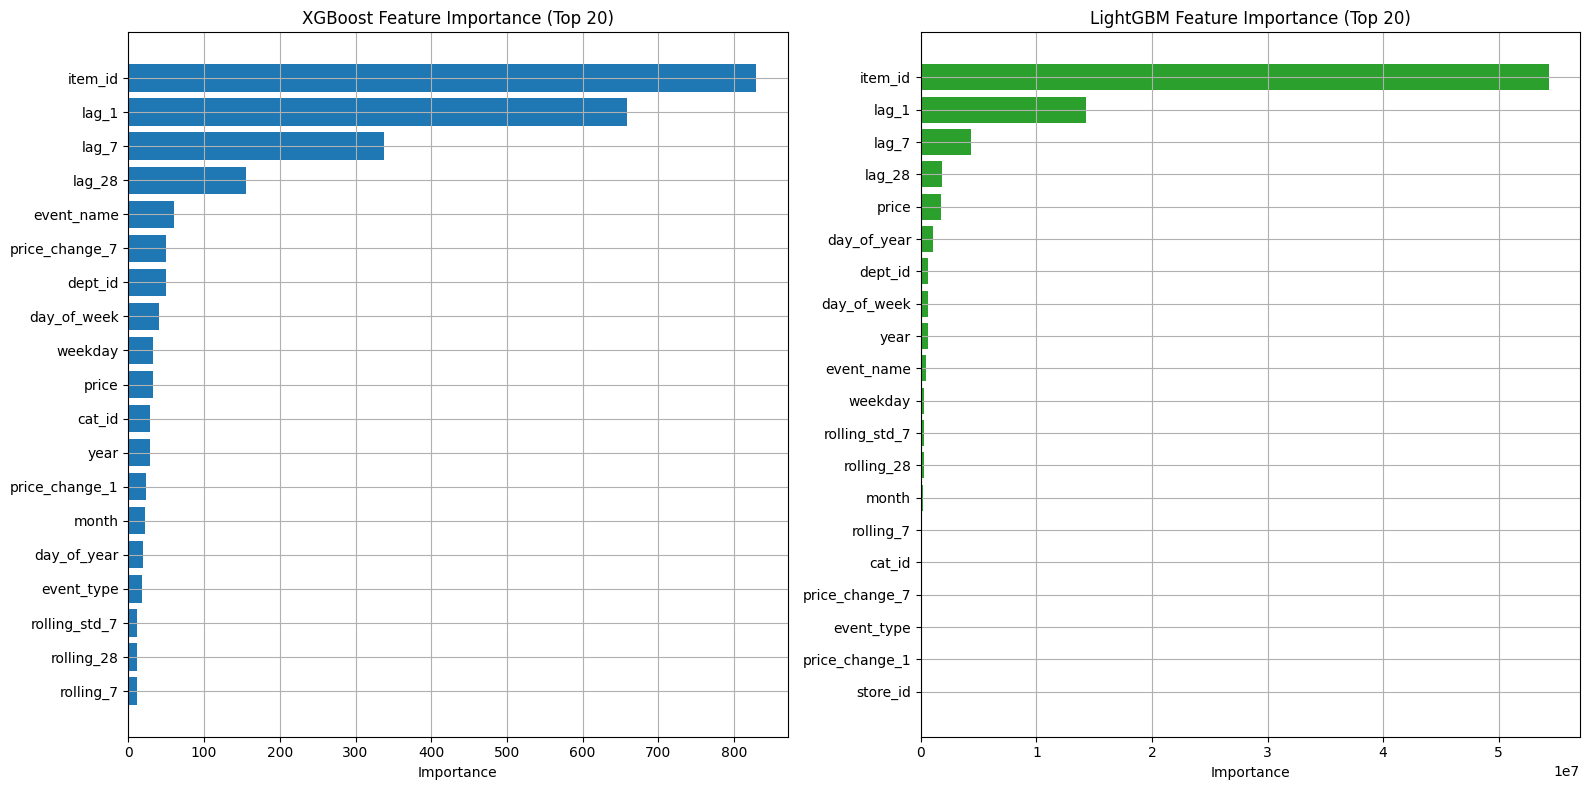

In [13]:
# Plot top-N feature importances for both models
TOP_N = 20

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
cols_to_drop = ["store_id", "item_id", "dept_id", "cat_id"]
xgb_importance_df = xgb_importance_df.drop(columns=[col for col in cols_to_drop if col in xgb_importance_df.columns])
lgbm_importance_df = lgbm_importance_df.drop(columns=[col for col in cols_to_drop if col in lgbm_importance_df.columns])
if not xgb_importance_df.empty:
    df = xgb_importance_df.head(TOP_N).sort_values("importance")
    axes[0].barh(df["feature"], df["importance"], color="#1f77b4")
    axes[0].set_title(f"XGBoost Feature Importance (Top {TOP_N})")
    axes[0].set_xlabel("Importance")
else:
    axes[0].text(0.5, 0.5, "No XGBoost importances", ha="center", va="center")
    axes[0].set_axis_off()

if not lgbm_importance_df.empty:
    df = lgbm_importance_df.head(TOP_N).sort_values("importance")
    axes[1].barh(df["feature"], df["importance"], color="#2ca02c")
    axes[1].set_title(f"LightGBM Feature Importance (Top {TOP_N})")
    axes[1].set_xlabel("Importance")
else:
    axes[1].text(0.5, 0.5, "No LightGBM importances", ha="center", va="center")
    axes[1].set_axis_off()

plt.tight_layout()
plt.show()